#### Import the required packages

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import persim
from numpy import random
import seaborn as sns
from persim.persistent_entropy import *
import gudhi.representations
import gudhi as gd
import csv
import os
import subprocess
sns.set_style("darkgrid")

## set the local path
# cmd = subprocess.Popen('pwd', stdout=subprocess.PIPE)
# cmd_out, cmd_err = cmd.communicate()
# local_path = os.fsdecode(cmd_out).strip()

#### Get the filenames and locations to load the persistence diagram datasets

In [5]:
directory_in_str = '../data/annotated_PH_2018_500/'
directory = os.fsencode(directory_in_str)

folders_region1 = []

for folder in os.listdir(directory):
    foldername = os.fsdecode(folder)
    if foldername.startswith('PH_640_'):
        folders_region1.append(foldername)
        foldername = foldername

folders_region2 = []

for folder in os.listdir(directory):
    foldername = os.fsdecode(folder)
    if foldername.startswith('PH_3_'):
        folders_region2.append(foldername)
        foldername = foldername

#### The networks with statistically similar weight distributions can be picked and analyzed using machine learning. In the following cell the relevant files are selected in lists file_tag_region1 and file_tag_region2. The persistence data is then loaded from those files.

In [ ]:
# ## Get the file tags

# file_tags_region1 = []
# with open(local_path+'/data/statistically_non-significant_2018_640.csv', 'r') as f:
#     reader = csv.reader(f)
#     for row in f:
#         file_tags_region1.append([int(float(x)) for x in row.strip().split(',')])
        
# file_tags_region2 = []
# with open(local_path+'/data/statistically_non-significant_2018_3.csv', 'r') as f:
#     reader = csv.reader(f)
#     for row in f:
#         file_tags_region2.append([int(float(x)) for x in row.strip().split(',')])

#### Get persistence data stored in files within the folder whose location is passed through the keyword argument path

In [6]:
number_of_edges_threshold = 0

"""
Returns persistence data
Inputs -- path: local_path
       -- starts_with: the string that the filenames start with if needed
       -- ends_with: the string that the filenames end with if needed
       -- threshold: number of edges threshold of the underlying vascular networks
"""

def get_data(path=None,starts_with=None,ends_with=None,threshold=None):
    files = [os.fsdecode(file) for file in os.listdir(path)]
    persistence_data={}
    for filename in files:
        if starts_with and ends_with:
            if filename.startswith(starts_with) and filename.endswith(ends_with):
                data = []
                with open(path+filename) as f:
                    reader = csv.reader(f)
                    for row in reader:
                        data.append([float(x) for x in row])
                if threshold == 0:
                    persistence_data[filename]=[item for item in data[1:] if item[1]!=np.inf]
                else:
                    if data[0][1] >= threshold:
                        persistence_data[filename]=[item for item in data[1:] if item[1]!=np.inf]
        elif starts_with:
            if filename.startswith(starts_with):
                data = []
                with open(path+filename) as f:
                    reader = csv.reader(f)
                    for row in reader:
                        data.append([float(x) for x in row])
                if threshold == 0:
                    persistence_data[filename]=[item for item in data[1:] if item[1]!=np.inf]
                else:
                    if data[0][1] >= threshold:
                        persistence_data[filename]=[item for item in data[1:] if item[1]!=np.inf]
        elif ends_with:
            if filename.endswith(ends_with):
                data = []
                with open(path+filename) as f:
                    reader = csv.reader(f)
                    for row in reader:
                        data.append([float(x) for x in row])
                if threshold == 0:
                    persistence_data[filename]=[item for item in data[1:] if item[1]!=np.inf]
                else:
                    if data[0][1] >= threshold:
                        persistence_data[filename]=[item for item in data[1:] if item[1]!=np.inf]
                
    return persistence_data

#### For comparitive analysis between vascular networks in bulk of mouse brain tissue -- region-1 vs. region-2

In [12]:
r1_PHs={}
for folder in folders_region1:
    r1_PHs[folder] = get_data('../data/annotated_PH_2018_500/'+folder+'/',starts_with=('ph_'),threshold=number_of_edges_threshold)

r2_PHs={}
for folder in folders_region2:
    r2_PHs[folder] = get_data('../data/annotated_PH_2018_500/'+folder+'/',starts_with=('ph_'),threshold=number_of_edges_threshold)

#### When doing the comparison/analysis with similar thickness distributions (2-sample ks_test used to pick similar samples)

In [9]:
# r1_ph_dataset = []
# for key,val in r1_PHs.items():
#     for subkey,subval in val.items():
#         l = [int(k) for k in subkey.split('_')[1:3]]
#         if l+[int(subkey.split('.')[0].split('_')[-1])] in file_tags_region1:
#             r1_ph_dataset.append(subval)
            
# r2_ph_dataset = []
# for key,val in r2_PHs.items():
#     for subkey,subval in val.items():
#         l = [int(k) for k in subkey.split('_')[1:3]]
#         if l+[int(subkey.split('.')[0].split('_')[-1])] in file_tags_region2:
#             r2_ph_dataset.append(subval)

## Downsampling
# indices = np.random.randint(0,len(r2_ph_dataset),len(r1_ph_dataset))
# r2_ph_dataset = [r2_ph_dataset[k] for k in indices]

#### Use the following helper function to get persistence data, which is stored within a dictionary of dictinoaries.

In [1]:
"""
Input -- persistence_data: a dictionary of folders consisting of dictionaries 
         of files whose values are the lists of persistence (b,d) pairs dataset
"""

def get_pd_aslist(persistence_data):
    pl_data = []
    for key,value in persistence_data.items():
        if value:
            for subkey,subvalue in value.items():
                pl_data.append(subvalue)
                if subvalue == []:
                    print(subkey)
    return pl_data

#### Loading the persistence data, downsampling (optional) and creating the labels for classification

In [14]:
r1_ph_dataset = get_pd_aslist(r1_PHs)
r2_ph_dataset = get_pd_aslist(r2_PHs)

## Downsampling
# random.seed(123)
# indices = np.random.randint(0,len(r2_ph_dataset),len(r1_ph_dataset))
# r2_ph_dataset = [r2_ph_dataset[k] for k in indices]

y=[]
for k in range(len(r1_ph_dataset)+len(r2_ph_dataset)):
    if k < len(r1_ph_dataset):
        y.append(0)
    elif k >= len(r1_ph_dataset):
        y.append(1)
        
dataset = [np.array(item) for item in r1_ph_dataset+r2_ph_dataset]

## Check that the number of samples is consistent depending on whether or not the downsampling is applied
print((sum(y)/len(y),len(y)))

(0.6739130434782609, 322)


#### Looking at the distribution of persistence entropies (PE) of vascular networks indicates if there is a distinction to be made between networks in region-1 vs. region-2. The concept of PE was first laid out in the followinig two paperes:

https://www.sciencedirect.com/science/article/abs/pii/S0031320314002453

https://link.springer.com/chapter/10.1007/978-3-319-29228-1_11

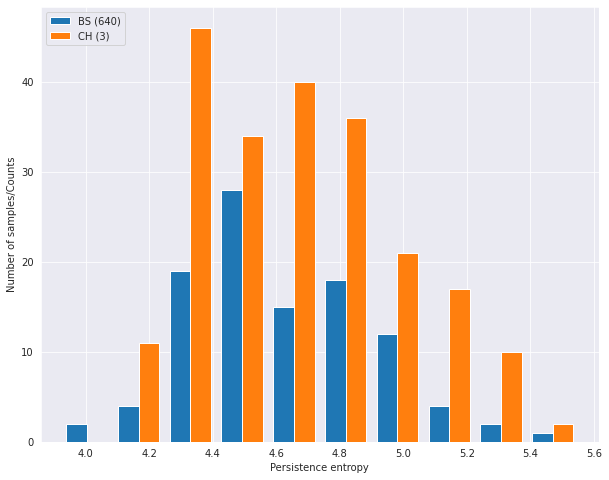

In [19]:
region1_entropy = []
for data in dataset[:len(r1_ph_dataset)]:
    region1_entropy.append(persistent_entropy(data)[0])
    
region2_entropy = []
for data in dataset[len(r1_ph_dataset):len(dataset)]:
    region2_entropy.append(persistent_entropy(data)[0])

    
## Distribution of samples with respect to persistence entropy
plt.figure(figsize=(10,8))
plt.hist([region1_entropy,region2_entropy],
         #bins = 20,
         #density=True,
         label=['BS (640)','CH (3)'])
plt.legend(loc='upper left')
plt.xlabel('Persistence entropy')
plt.ylabel('Number of samples/Counts')
plt.show()

#### 2-sample Kolmogrov-Smirnov test & Mann-Whitney U test indicate that the distrbutions are statistically similar

https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test

https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test

In [20]:
from scipy.stats import ks_2samp
from scipy.stats import mannwhitneyu

stat, p_val= ks_2samp(region1_entropy,region2_entropy)
print(f'kstest between entropy distributions: {stat, p_val}')
stat, p_val= mannwhitneyu(region1_entropy,region2_entropy)
print(f'mannwhitneyu between entropy distributions: {stat, p_val}')

kstest between entropy distributions: (0.11981566820276497, 0.237849433067423)
mannwhitneyu between entropy distributions: (10446.0, 0.11352949029749099)


#### A box-plot can be used to examine distributions of PE

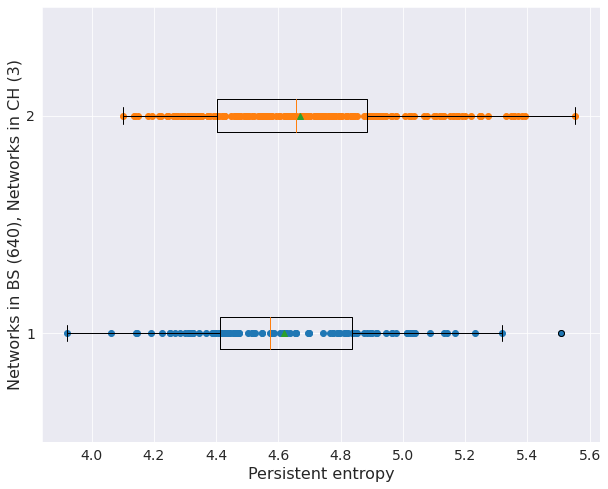

In [23]:
plt.figure(figsize=(10,8)) 
plt.boxplot([region1_entropy,region2_entropy],vert=False,showmeans=True)
plt.scatter(region1_entropy,np.ones(len(region1_entropy)))
plt.scatter(region2_entropy,1+np.ones(len(region2_entropy)))
plt.xlabel("Persistent entropy",fontsize=16)
plt.ylabel("Networks in BS (640), Networks in CH (3)",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);
# plt.savefig('2018_CH_BS_persistent_entropy.jpg');

#### Persistence landscapes. 

Persistence landscapees are piecewise linear functions that are generated using persistence diagrams. These are vectors in a Hilbert space and thus are amenable to training a machine learning algorithm (https://jmlr.org/papers/v16/bubenik15a.html).

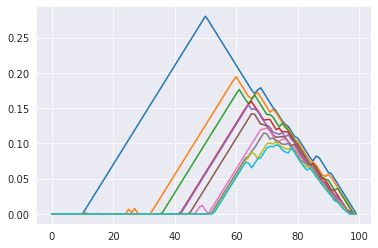

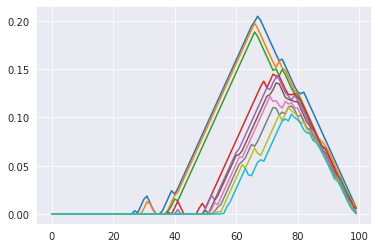

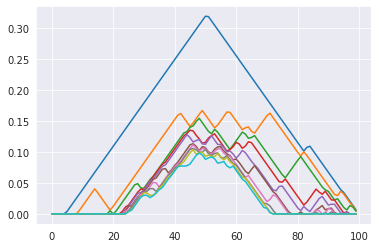

In [24]:
## Specify the resolution of the landscapes 
resolution = 100
## Specify the number of landscapes. The order of landscapes is inversely proportional to their persistence. 
num_landscapes = 10
LS = gd.representations.Landscape(resolution = resolution,num_landscapes=num_landscapes)
K = LS.num_landscapes

## Plot landscapes from region-2
L = LS.fit_transform([dataset[-3],dataset[-1],dataset[-2]])
for idx, landscape in enumerate(L):
    for k in range(K):
        plt.plot(landscape[k*resolution: (k+1)*resolution])
    plt.show()

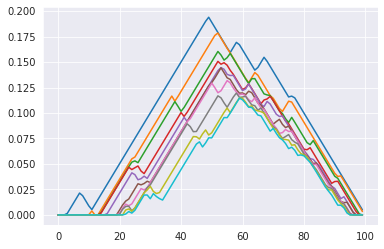

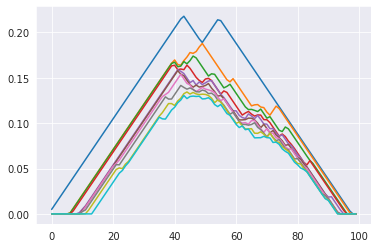

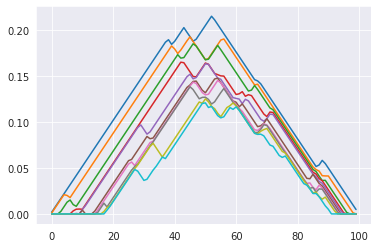

In [25]:
## Plot landscapes from region-2
L = LS.fit_transform([dataset[3],dataset[1],dataset[2]])
for idx, landscape in enumerate(L):
    for k in range(K):
        plt.plot(landscape[k*resolution: (k+1)*resolution])
    plt.show()

#### Machine learning pipeline. 
The design of the pipeline is guided by the some of the scripts in following repository: https://github.com/GUDHI/TDA-tutorial.

In [33]:
# from sklearn.svm import LinearSVC
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import GridSearchCV

# resolution = 10

# pipe = Pipeline(steps=[
#     ("tda",LS),
#     ('classifier',LinearSVC(max_iter=100000))
# ])


# param_grid = {
#     'tda__num_landscapes':[10],
#     'classifier__C':np.logspace(-2,3,10) 
# }

# model = GridSearchCV(pipe, param_grid, n_jobs=12, cv = 10, scoring='accuracy')

from sklearn.preprocessing   import MinMaxScaler
from sklearn.pipeline        import Pipeline
from sklearn.svm             import LinearSVC
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier

## Construct pipeline
pipe = Pipeline([#("Separator", gd.representations.DiagramSelector(limit=np.inf, point_type="finite")),
                 ("Scaler",    gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),
                 ("TDA",       gd.representations.PersistenceImage()),
                 ("Estimator", SVC())])

## Specify the parameters of pipeline.
## This is the place where you specify the methods you want to use to handle diagrams
param =    {"Scaler__use":         [False],
             "TDA":                 [gd.representations.SlicedWassersteinKernel()], 
             "TDA__bandwidth":      [0.1, 1.0],
             "TDA__num_directions": [20],
             "Estimator":           [SVC(kernel="precomputed", gamma="auto")]}

#### Train-test split

In [27]:
from sklearn.model_selection import train_test_split
## for balanced dataset
from sklearn.metrics import accuracy_score
## for imbalanced dataset
from sklearn.metrics import f1_score

## while doing cross-validation, this is optional
ph_train, ph_test, y_train, y_test = train_test_split(dataset, y,
                                                      test_size = 0.1,
                                                      random_state=123,
                                                      shuffle=True,
                                                      stratify=y)

#### Finding optimal parameter setting through GridSearch CV

In [29]:
from sklearn.model_selection import GridSearchCV

model = GridSearchCV(pipe, param, cv=10, n_jobs=10, scoring='f1')

model.fit(ph_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('Scaler',
                                        DiagramScaler(scalers=[([0, 1],
                                                                MinMaxScaler())])),
                                       ('TDA', PersistenceImage()),
                                       ('Estimator', SVC())]),
             n_jobs=10,
             param_grid={'Estimator': [SVC(gamma='auto', kernel='precomputed')],
                         'Scaler__use': [False],
                         'TDA': [SlicedWassersteinKernel(num_directions=20)],
                         'TDA__bandwidth': [0.1, 1.0],
                         'TDA__num_directions': [20]},
             scoring='f1')

#### The score and the parameter setting of the model with best score

In [30]:
print((model.best_score_,model.best_params_))

(0.8240622125637914, {'Estimator': SVC(gamma='auto', kernel='precomputed'), 'Scaler__use': False, 'TDA': SlicedWassersteinKernel(num_directions=20), 'TDA__bandwidth': 1.0, 'TDA__num_directions': 20})


#### The model score for the test set

In [31]:
y_predicted=model.best_estimator_.predict(ph_test)

f1_score(y_test,y_predicted)

0.8695652173913043

#### To generate a plot of hyper-parameter tuning using cross-validation

In [34]:
final_model = Pipeline(steps=[
    #('separator',gd.representations.DiagramSelector(limit=np.inf, point_type="finite")),
    ('scaler',gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),
    ('tda',gd.representations.Landscape(resolution=10,num_landscapes=10)),
    ('classifier',LinearSVC(max_iter=50000))
])

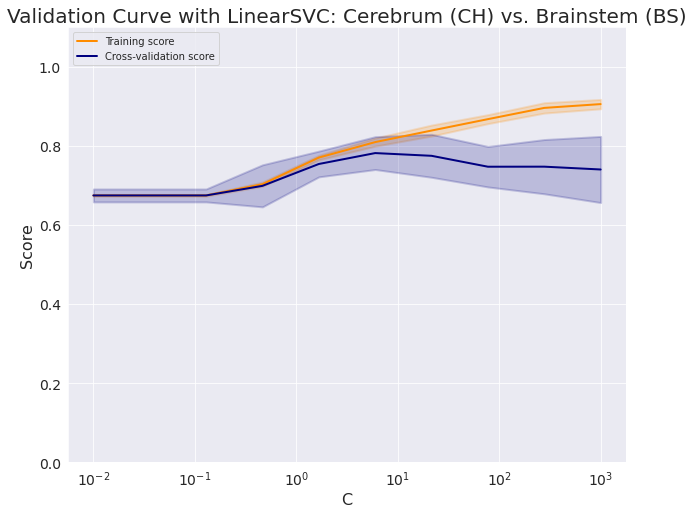

In [35]:
from sklearn.model_selection import validation_curve

param_range = np.logspace(-2, 3, 10)

train_scores, test_scores = validation_curve(
    final_model,
    ph_train,
    y_train,
    param_name="classifier__C",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=12,
    cv=10
)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# with open('../balanced_dataset_ml_anlys/balanced_2018_640_3_rescaled_shuffled_eval_metrics.csv','a') as f:
#     writer = csv.writer(f)
#     writer.writerow(test_scores_mean)
#     writer.writerow(test_scores_std)
#     writer.writerow(train_scores_mean)
#     writer.writerow(train_scores_std)
    
# with open(local_path+'/plots_hypparam_opt_reweighed/reweighed_shuffled_eval_metrics.csv','a') as f:
#     writer = csv.writer(f)
#     writer.writerow(test_scores_mean)
#     writer.writerow(test_scores_std)
#     writer.writerow(train_scores_mean)
#     writer.writerow(train_scores_std)

plt.figure(figsize=(10,8))
plt.title("Validation Curve with LinearSVC: Cerebrum (CH) vs. Brainstem (BS)",fontsize=20)
plt.xlabel("C",fontsize=16)
plt.ylabel("Score",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    param_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    param_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
plt.legend(loc="upper left")
#plt.savefig('../balanced_dataset_ml_anlys/balanced_2018_640_3_rescaled_shuffled_CV.jpg')
plt.show()

#### Take a deeper look using classification report

In [36]:
from sklearn.metrics import classification_report

## get the output as a dictionary 
# classification_report(y_test, y_predicted, target_names=['0','1'],output_dict=True)

print('Testing Error metrics')
print(classification_report(y_test, y_predicted, target_names=['0','1']))
print('\n')
print('Training Error metrics')
print(classification_report(y_train, model.best_estimator_.predict(ph_train), target_names=['0','1']))

Testing Error metrics
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.83      0.91      0.87        22

    accuracy                           0.82        33
   macro avg       0.81      0.77      0.78        33
weighted avg       0.81      0.82      0.81        33



Training Error metrics
              precision    recall  f1-score   support

           0       0.95      0.80      0.87        94
           1       0.91      0.98      0.94       195

    accuracy                           0.92       289
   macro avg       0.93      0.89      0.91       289
weighted avg       0.92      0.92      0.92       289



#### A more succinct notation to evaluate the performance on the test set

In [37]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_confusion_matrix(y_test,y_predicted)

array([[[20,  2],
        [ 4,  7]],

       [[ 7,  4],
        [ 2, 20]]])

#### When using linear classifiers, the coefficients of the trained model can be extracted

In [54]:
# coefs = model.best_estimator_['Estimator'].coef_
# sns.heatmap(coef);

## save the model coefs

# import csv

# with open(local_path+"/model_200_4.csv","a") as csvfile:
#     writer=csv.writer(csvfile)
#     for item in pipeline['clf'].coef_:
#         writer.writerow(item)

#### A 2D embedding of networks using TSNE

In [49]:
from sklearn.manifold import TSNE

embedding = TSNE(2)

viz_pipe = Pipeline([
    ('scaler',gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),
    ("tda", gd.representations.Landscape(resolution=10,num_landscapes=10)),
    ("mds", embedding)
])

y = np.array(y)
X_tsne = viz_pipe.fit_transform(dataset)

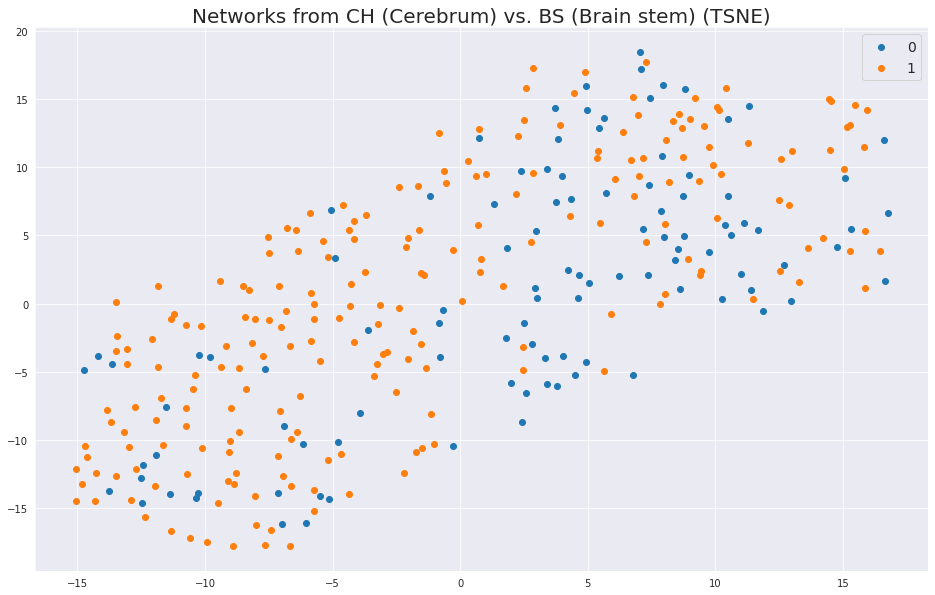

In [50]:
plt.figure(figsize=(16,10))

for i in range(2):
    plt.scatter(X_tsne[y==i,0], X_tsne[y==i,1], label=i)

plt.legend(fontsize=14)
plt.title("Networks from CH (Cerebrum) vs. BS (Brain stem) (TSNE)", fontsize=20)

plt.show()

#### The schematic of the pipeline can be drawn as follows

In [53]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline(steps=[
            ('separator',gd.representations.DiagramSelector(limit=np.inf, point_type="finite")),
            ('scaler',gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),
            ('tda',gd.representations.Landscape(resolution=10,num_landscapes=10)),
            ('classifier',LinearSVC(max_iter=500000))
        ])

set_config(display="diagram")
pipe

Pipeline(steps=[('separator', DiagramSelector()),
                ('scaler', DiagramScaler(scalers=[([0, 1], MinMaxScaler())])),
                ('tda', Landscape(num_landscapes=10, resolution=10)),
                ('classifier', LinearSVC(max_iter=500000))])